<a href="https://colab.research.google.com/github/darshan-analytics/multilabel_image_classification_using_CNN/blob/main/multilabel_lmage_classifier_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import Image


In [85]:
import tensorflow as tf
import pathlib
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
from functools import partial
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install --quiet -U git+https://github.com/qubvel/efficientnet
!pip install --quiet -U git+https://github.com/albumentations-team/albumentations
import efficientnet.keras as efn 
import albumentations as A

In [95]:
url = 'https://drive.google.com/uc?id=1Zqyfgf7OFxubkM_5XqyWg1nvzz54GY75'
!gdown {url}
!unzip -q data.zip
!rm data.zip
data_dir = '/content/data/'

Downloading...
From: https://drive.google.com/uc?id=1Zqyfgf7OFxubkM_5XqyWg1nvzz54GY75
To: /content/data.zip
21.1MB [00:00, 185MB/s]
replace data/cats/00000166.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
data_dir = pathlib.Path(data_dir)
images_list = data_dir.glob('*/*.jpg')
images_list = [str(x) for x in images_list]
np.random.seed(2020)
np.random.shuffle(images_list)

def get_label_from_path(path):
  #print(path)
  # Extract the label (string) from the path 
  #label = '/'.join(path.split(os.sep)[2].split('/')[:-1]).lower()
  label = '_'.join(path.split(os.sep)[-2].split('/')).lower()

  return label

labels_list = [get_label_from_path(x) for x in images_list]
labels = list(set(labels_list))
labels_to_num = dict(zip(labels, range(len(labels))))
labels_list = [labels_to_num[x] for x in labels_list]
print(len(labels))

3


In [5]:
labels

['bearcats', 'bears', 'cats']

In [6]:
images_list

['/content/data/bears/00000185.jpg',
 '/content/data/bears/00000002.jpg',
 '/content/data/bears/00000145.jpg',
 '/content/data/cats/00000129.jpg',
 '/content/data/cats/00000101.jpg',
 '/content/data/bearcats/00000137.jpg',
 '/content/data/bears/00000194.jpg',
 '/content/data/bears/00000043.jpg',
 '/content/data/cats/00000010.jpg',
 '/content/data/bears/00000072.jpg',
 '/content/data/bears/00000028.jpg',
 '/content/data/bears/00000077.jpg',
 '/content/data/cats/00000192.jpg',
 '/content/data/cats/00000099.jpg',
 '/content/data/bears/00000062.jpg',
 '/content/data/bearcats/00000021.jpg',
 '/content/data/cats/00000000.jpg',
 '/content/data/bears/00000037.jpg',
 '/content/data/cats/00000124.jpg',
 '/content/data/bears/00000108.jpg',
 '/content/data/bears/00000182.jpg',
 '/content/data/bearcats/00000074.jpg',
 '/content/data/cats/00000186.jpg',
 '/content/data/cats/00000117.jpg',
 '/content/data/cats/00000103.jpg',
 '/content/data/cats/00000072.jpg',
 '/content/data/bearcats/00000129.jpg',


In [8]:
from collections import Counter

In [9]:
Counter(labels_list).items()
#cats :1   bearcats :2 bears:0

dict_items([(1, 180), (2, 162), (0, 168)])

In [10]:
Counter(labels_list).values()

dict_values([180, 162, 168])

In [11]:
all_data = tf.data.Dataset.from_tensor_slices((images_list, labels_list))
print(len(all_data))


510


In [12]:
data_train = all_data.take(350) 
data_val = all_data.skip(350)

In [13]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [15]:
transforms_train = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1),
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

transforms_val = A.Compose([
            A.Resize(IMG_SIZE[0], IMG_SIZE[1], p=1)
        ])


def aug_fn(image, train):
    data = {"image": image}
    if train:
      data = transforms_train(**data)
    else:
      data = transforms_val(**data)
    aug_img = data["image"]
    aug_img = efn.preprocess_input(aug_img)
    return aug_img

def parse(path, label):
    
    image = tf.io.read_file(path)

    image = tf.io.decode_jpeg(image, channels=3)
    label = tf.one_hot(label, 3)
    return image, label

def process_data_train(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, True], 
                                Tout=tf.float32)
    return aug_img, label

def process_data_val(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, False], 
                                Tout=tf.float32)
    return aug_img, label



In [16]:
from tensorflow.data.experimental import AUTOTUNE

data_train = data_train.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_train,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
                  
data_val = data_val.shuffle(buffer_size=BATCH_SIZE*4).map(parse, 
                  num_parallel_calls=AUTOTUNE).cache().map(process_data_val,
                  num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

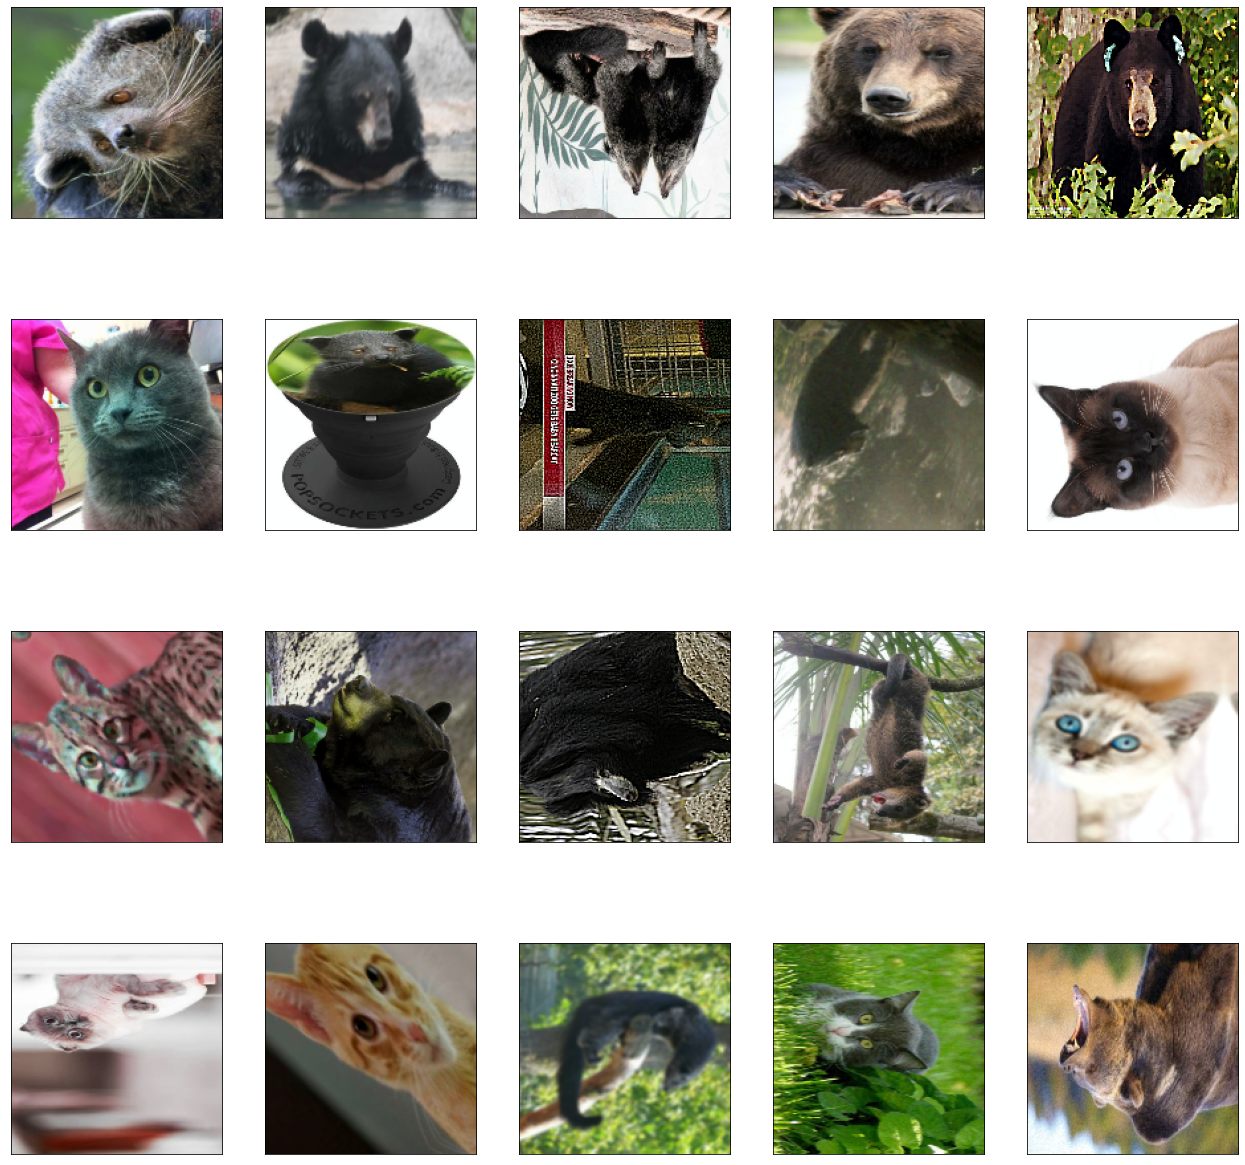

In [17]:
def view_image_batch(ds):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image, _ = next(iter(ds)) # extract 1 batch from the dataset
    image = np.clip((image.numpy()*std)+mean,0,1) # Doing the efn.preprocess_input inverse 

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])

view_image_batch(data_train)

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False) # BN Will always be in inference mode, i.e. using running stats
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x=data_train, validation_data=data_val, epochs=10)

Epoch 1/10
11/11 [==============================] - 16s 1s/step - loss: 0.9343 - accuracy: 0.5800 - val_loss: 0.5282 - val_accuracy: 0.8813
Epoch 2/10
11/11 [==============================] - 14s 1s/step - loss: 0.5775 - accuracy: 0.8114 - val_loss: 0.3284 - val_accuracy: 0.9438
Epoch 3/10
11/11 [==============================] - 15s 1s/step - loss: 0.4066 - accuracy: 0.9029 - val_loss: 0.2435 - val_accuracy: 0.9625
Epoch 4/10
11/11 [==============================] - 14s 1s/step - loss: 0.3522 - accuracy: 0.8857 - val_loss: 0.2020 - val_accuracy: 0.9688
Epoch 5/10
11/11 [==============================] - 15s 1s/step - loss: 0.3147 - accuracy: 0.8971 - val_loss: 0.1809 - val_accuracy: 0.9688
Epoch 6/10
11/11 [==============================] - 14s 1s/step - loss: 0.3017 - accuracy: 0.8914 - val_loss: 0.1708 - val_accuracy: 0.9625
Epoch 7/10
11/11 [==============================] - 15s 1s/step - loss: 0.2735 - accuracy: 0.9200 - val_loss: 0.1612 - val_accuracy: 0.9625
Epoch 8/10
11/11 [==

In [53]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs) # No BN inference forcing
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(3)(x)
model = tf.keras.Model(inputs, outputs)

base_model.trainable = True
for layer in base_model.layers:
  if 'bn' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x=data_train, validation_data=data_val, epochs=10)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 45,859
Non-trainable params: 4,007,548
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 39s 4s/step - loss: 1.0864 - accuracy: 0.4286 - val_l

In [20]:
base_model.trainable = True 
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 4,011,391
Non-trainable params: 42,016
_________________________________________________________________


In [21]:
from keras.callbacks import ModelCheckpoint

In [22]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(data_train, validation_data = data_val, epochs=10, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.95000, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.95000 to 0.96250, saving model to weights.best.hdf5

Epoch 00003: val_accuracy did not improve from 0.96250

Epoch 00004: val_accuracy improved from 0.96250 to 0.97500, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.97500

Epoch 00006: val_accuracy did not improve from 0.97500

Epoch 00007: val_accuracy improved from 0.97500 to 0.98125, saving model to weights.best.hdf5

Epoch 00008: val_accuracy did not improve from 0.98125

Epoch 00009: val_accuracy did not improve from 0.98125

Epoch 00010: val_accuracy did not improve from 0.98125


In [23]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = efn.EfficientNetB0(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs) # No BN inference forcing
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  
outputs = tf.keras.layers.Dense(3, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

base_model.trainable = True
for layer in base_model.layers:
  if 'bn' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits= True),
              metrics=['accuracy'])

model.fit(x=data_train, validation_data=data_val, epochs=10)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 45,859
Non-trainable params: 4,007,548
_________________________________________________________________
Epoch 1/10
11/11 [==============================] - 40s 4s/step - loss: 0.7720 - accuracy: 0.4200 - val_l

In [24]:
metrics=[tf.keras.metrics.BinaryAccuracy(name=str(t), threshold=t) for t in np.linspace(0.5, 1.0, 20)]

In [75]:
def model_eval(data):
  results = model.predict(data)
  position_of_element = results.argmax()

  if results[0,position_of_element] > 0.75:
    if position_of_element == 0:
      bearcat_type = "The given image is of type Bearcat"
      return bearcat_type
    if position_of_element == 1:
      bear_type = "The given image is of type Bear"
      return bear_type
    if position_of_element == 2:
      cat_type = "The given image is of type Cat"
      return cat_type
  else:
    niether_type = "Image does not classified as Bearcat, Bear or Cat category"
    return niether_type
    

  


In [41]:
loss_train = model.evaluate(data_train, batch_size=32)
print("train loss and train acc", loss_train)
loss_val = model.evaluate(data_val, batch_size=32)
print("val loss and val acc",loss_val)

11/11 [==============================] - 9s 859ms/step - loss: 0.6248 - accuracy: 0.9229
train loss and train acc [0.6248080730438232, 0.9228571653366089]
5/5 [==============================] - 3s 670ms/step - loss: 0.6253 - accuracy: 0.9563
val loss and val acc [0.6253455877304077, 0.956250011920929]


In [79]:
def parse_and_process(url): 
  image_path = tf.keras.utils.get_file(url.split('/')[-1], url)
  image_raw = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image_raw)
  image = tf.image.resize(image, IMG_SIZE)
  image = efn.preprocess_input(image)
  image = tf.expand_dims(image, axis=0)
  return image

url1 = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
url2 = 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg'
url4 = 'https://img-aws.ehowcdn.com/750x428p/photos.demandstudios.com/getty/article/133/202/200329496-001_XS.jpg'
url5 = 'https://i.insider.com/5ecba7a62618b94bad606b75?width=700&format=jpeg&auto=webp'

test_case_1 = parse_and_process(url1)
test_case_2 = parse_and_process(url2)
test_case_3 = np.random.rand(1,160,160,3)
test_case_4 = parse_and_process(url4)
test_case_5 = parse_and_process(url5)

results_check_for_element_1 = model_eval(test_case_1)
print("Results for test_case_1: ", results_check_for_element_1)
results_check_for_element_2 = model_eval(test_case_2)
print("Results for test_case_2: ", results_check_for_element_2)
results_check_for_element_3 = model_eval(test_case_3)
print("Results for test_case_3: ", results_check_for_element_3)
results_check_for_element_4 = model_eval(test_case_4)
print("Results for test_case_4: ", results_check_for_element_4)
results_check_for_element_5 = model_eval(test_case_5)
print("Results for test_case_5: ", results_check_for_element_5)

Results for test_case_1:  Image does not classified as Bearcat, Bear or Cat category
Results for test_case_2:  The given image is of type Cat
Results for test_case_3:  Image does not classified as Bearcat, Bear or Cat category
Results for test_case_4:  The given image is of type Bearcat
Results for test_case_5:  The given image is of type Bear
